# Trialling UMAP

In [61]:
import napari
from macrohet import dataio, tile
import btrack
print(btrack.__version__)
import os
from tqdm.auto import tqdm
import numpy as np
import umap
import seaborn
import pandas as pd
from sklearn.preprocessing import StandardScaler

0.6.1.dev30


### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [6]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!


### Define row and column of choice

In [7]:
row = 3
column = 5

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [8]:
image_dir = os.path.join(base_dir, 'macrohet_images/Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
#                              set_channel=1,
                             set_time = 0,
#                             input_transforms = [input_transforms]
                            ).compute().compute()

In [9]:
gfp = images[0,0,...]

In [10]:
rfp = images[0,1,...]

# Load tracks

In [11]:
tracks_fn = os.path.join(base_dir, f'labels/macrohet_seg_model/{row, column}.h5')
with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
    tracks = hdf.tracks
    segmentation = hdf.segmentation
    objects = hdf.objects
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)

[INFO][2023/05/18 02:00:37 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/05/18 02:00:37 PM] Loading tracks/obj_type_1
[INFO][2023/05/18 02:00:37 PM] Loading LBEP/obj_type_1
[INFO][2023/05/18 02:00:37 PM] Loading objects/obj_type_1 (41894, 5) (41894 filtered: None)
[INFO][2023/05/18 02:00:47 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/05/18 02:00:47 PM] Loading objects/obj_type_1 (41894, 5) (41894 filtered: None)
[INFO][2023/05/18 02:00:48 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


In [12]:
masks = segmentation[0]

# Running UMAP on previously measured properties

In [13]:
objects_t0 = [o for o in objects if o.t ==0]

In [16]:
type(objects_t0)

list

In [26]:
objects_t0[0].to_dict()

{'ID': 0,
 'x': 743.4783325195312,
 'y': 86.11271667480469,
 'z': 0.0,
 't': 0,
 'dummy': False,
 'states': 7,
 'label': 5,
 'major_axis_length': 107.25926,
 'mean_intensity': array([3482.899   ,  404.28018 ,   57.099625], dtype=float32),
 'minor_axis_length': 79.8617,
 'Infected': 1.0,
 'area': 6685.0,
 'orientation': 0.5241751}

#### Add total GFP signal to properties

In [31]:
obj = objects_t0[0]

In [32]:
obj.properties['mean_intensity']

array([3482.899   ,  404.28018 ,   57.099625], dtype=float32)

In [42]:
for obj in tqdm(objects_t0):
    # calcualte the sum intensity
    mean_intensity = obj.properties['mean_intensity']
    area = obj.properties['area']
    sum_intensity = [ch_int * area for ch_int in mean_intensity]
    obj.properties['sum_intensity'] = sum_intensity 
    # Assign individual mean intensity values to separate keys
    obj.properties['mean_intensity_0'] = mean_intensity[0]
    obj.properties['mean_intensity_1'] = mean_intensity[1]
    obj.properties['mean_intensity_2'] = mean_intensity[2]
    # Remove the original 'mean_intensity' key if desired
    del obj.properties['mean_intensity']
    # Assign individual sum intensity values to separate keys
    obj.properties['sum_intensity_0'] = sum_intensity[0]
    obj.properties['sum_intensity_1'] = sum_intensity[1]
    obj.properties['sum_intensity_2'] = sum_intensity[2]
    # Remove the original 'sum_intensity' key if desired
    del obj.properties['sum_intensity']
    # calculate the eccentricity
    major_axis_length = obj.properties['major_axis_length']
    minor_axis_length = obj.properties['minor_axis_length']
    eccentricity = np.sqrt(1 - (minor_axis_length / major_axis_length) ** 2)
    obj.properties['eccentricity'] = eccentricity

  0%|          | 0/640 [00:00<?, ?it/s]

In [43]:
obj.properties

{'major_axis_length': 413.91708,
 'minor_axis_length': 191.53806,
 'Infected': 0.0,
 'area': 53466.0,
 'orientation': 1.3507292,
 'eccentricity': 0.886491445256287,
 'mean_intensity_0': 3282.3574,
 'mean_intensity_1': 349.79428,
 'mean_intensity_2': 0.0,
 'sum_intensity_0': 175494530.0,
 'sum_intensity_1': 18702102.0,
 'sum_intensity_2': 0.0}

In [44]:
df = pd.DataFrame([obj.to_dict() for obj in objects_t0])

In [45]:
df

ID           x            y    z  t  dummy  states  label  \
0        0  743.478333    86.112717  0.0  0  False       7      5   
1        4   53.950829    33.571297  0.0  0  False       7      5   
2       30  616.366272   701.684753  0.0  0  False       7      5   
3       43  767.023743     3.037694  0.0  0  False       7      5   
4       45  864.839661    11.981962  0.0  0  False       7      5   
..     ...         ...          ...  ... ..    ...     ...    ...   
635  21401  194.976562  1191.021118  0.0  0  False       7      5   
636  21405  892.645630  1193.496216  0.0  0  False       7      5   
637  21475  595.976074  1193.786743  0.0  0  False       7      5   
638  21480  733.371826  1194.681030  0.0  0  False       7      5   
639  21495  798.458252  1184.806274  0.0  0  False       7      5   

     major_axis_length  minor_axis_length  Infected     area  orientation  \
0           107.259262          79.861702       1.0   6685.0     0.524175   
1           346.958527         144.736496       1.0  38419.0     0.883217   
2           311.702698         210.252716       0.0  45563.0    -1.048041   
3           137.468872          28.172792       1.0   2826.0    -1.546340   
4           237.021744         138.517944       1.0  25128.0     1.417091   
..                 ...                ...       ...      ...          ...   
635          98.088501          93.639648       0.0   7135.0    -0.756040   
636         139.786301          72.168739       0.0   7513.0    -1.336970   
637          89.565765          68.595749       0.0   4484.0     1.516814   
638          88.614616          60.696877       0.0   4120.0     1.550278   
639         413.917084         191.538055       0.0  53466.0     1.350729   

     eccentricity  mean_intensity_0  mean_intensity_1  mean_intensity_2  \
0        0.667548       3482.898926        404.280182         57.099625   
1        0.908834       1586.561401        345.921570          0.331997   
2        0.738248       2098.337402        379.339844          0.000000   
3        0.978775       1485.459717        375.619598         57.366596   
4        0.811458       1712.924072        359.880798         17.158150   
..            ...               ...               ...               ...   
635      0.297748       2238.592529        366.866302          0.000000   
636      0.856420       2405.480957        353.086517          0.000000   
637      0.642995       1200.062256        357.139160          0.000000   
638      0.728587       1746.521851        352.815765          0.000000   
639      0.886491       3282.357422        349.794281          0.000000   

     sum_intensity_0  sum_intensity_1  sum_intensity_2  
0         23283180.0        2702613.0         381711.0  
1         60954104.0       13289961.0          12755.0  
2         95606544.0       17283862.0              0.0  
3          4197909.0        1061501.0         162118.0  
4         43042356.0        9043085.0         431150.0  
..               ...              ...              ...  
635       15972358.0        2617591.0              0.0  
636       18072378.0        2652739.0              0.0  
637        5381079.0        1601412.0              0.0  
638        7195670.0        1453601.0              0.0  
639      175494528.0       18702102.0              0.0  

[640 rows x 20 columns]

### Feature selection

In [86]:
selected_table = df#[
#     [
#         "mean_intensity_0",
#         "area",
#         "sum_intensity_0",
#     ]
# ]

selected_statistics = selected_table.values

In [87]:
selected_statistics

array([[0, 743.4783325195312, 86.11271667480469, ..., 381711.0,
        -3.66232967376709, 6.316184043884277],
       [4, 53.950828552246094, 33.57129669189453, ..., 12755.0,
        7.291450500488281, 4.156863212585449],
       [30, 616.3662719726562, 701.6847534179688, ..., 0.0,
        6.067001819610596, 7.271661758422852],
       ...,
       [21475, 595.97607421875, 1193.7867431640625, ..., 0.0,
        5.363314151763916, 0.8867886066436768],
       [21480, 733.371826171875, 1194.6810302734375, ..., 0.0,
        3.2489922046661377, 1.4697234630584717],
       [21495, 798.458251953125, 1184.8062744140625, ..., 0.0,
        6.580105304718018, 10.736964225769043]], dtype=object)

In [88]:
scaled_statistics = StandardScaler().fit_transform(selected_statistics)

type(scaled_statistics), scaled_statistics.shape

(numpy.ndarray, (640, 22))

## Plotting
For demonstration purposes, we plot the three selected features against each other. 

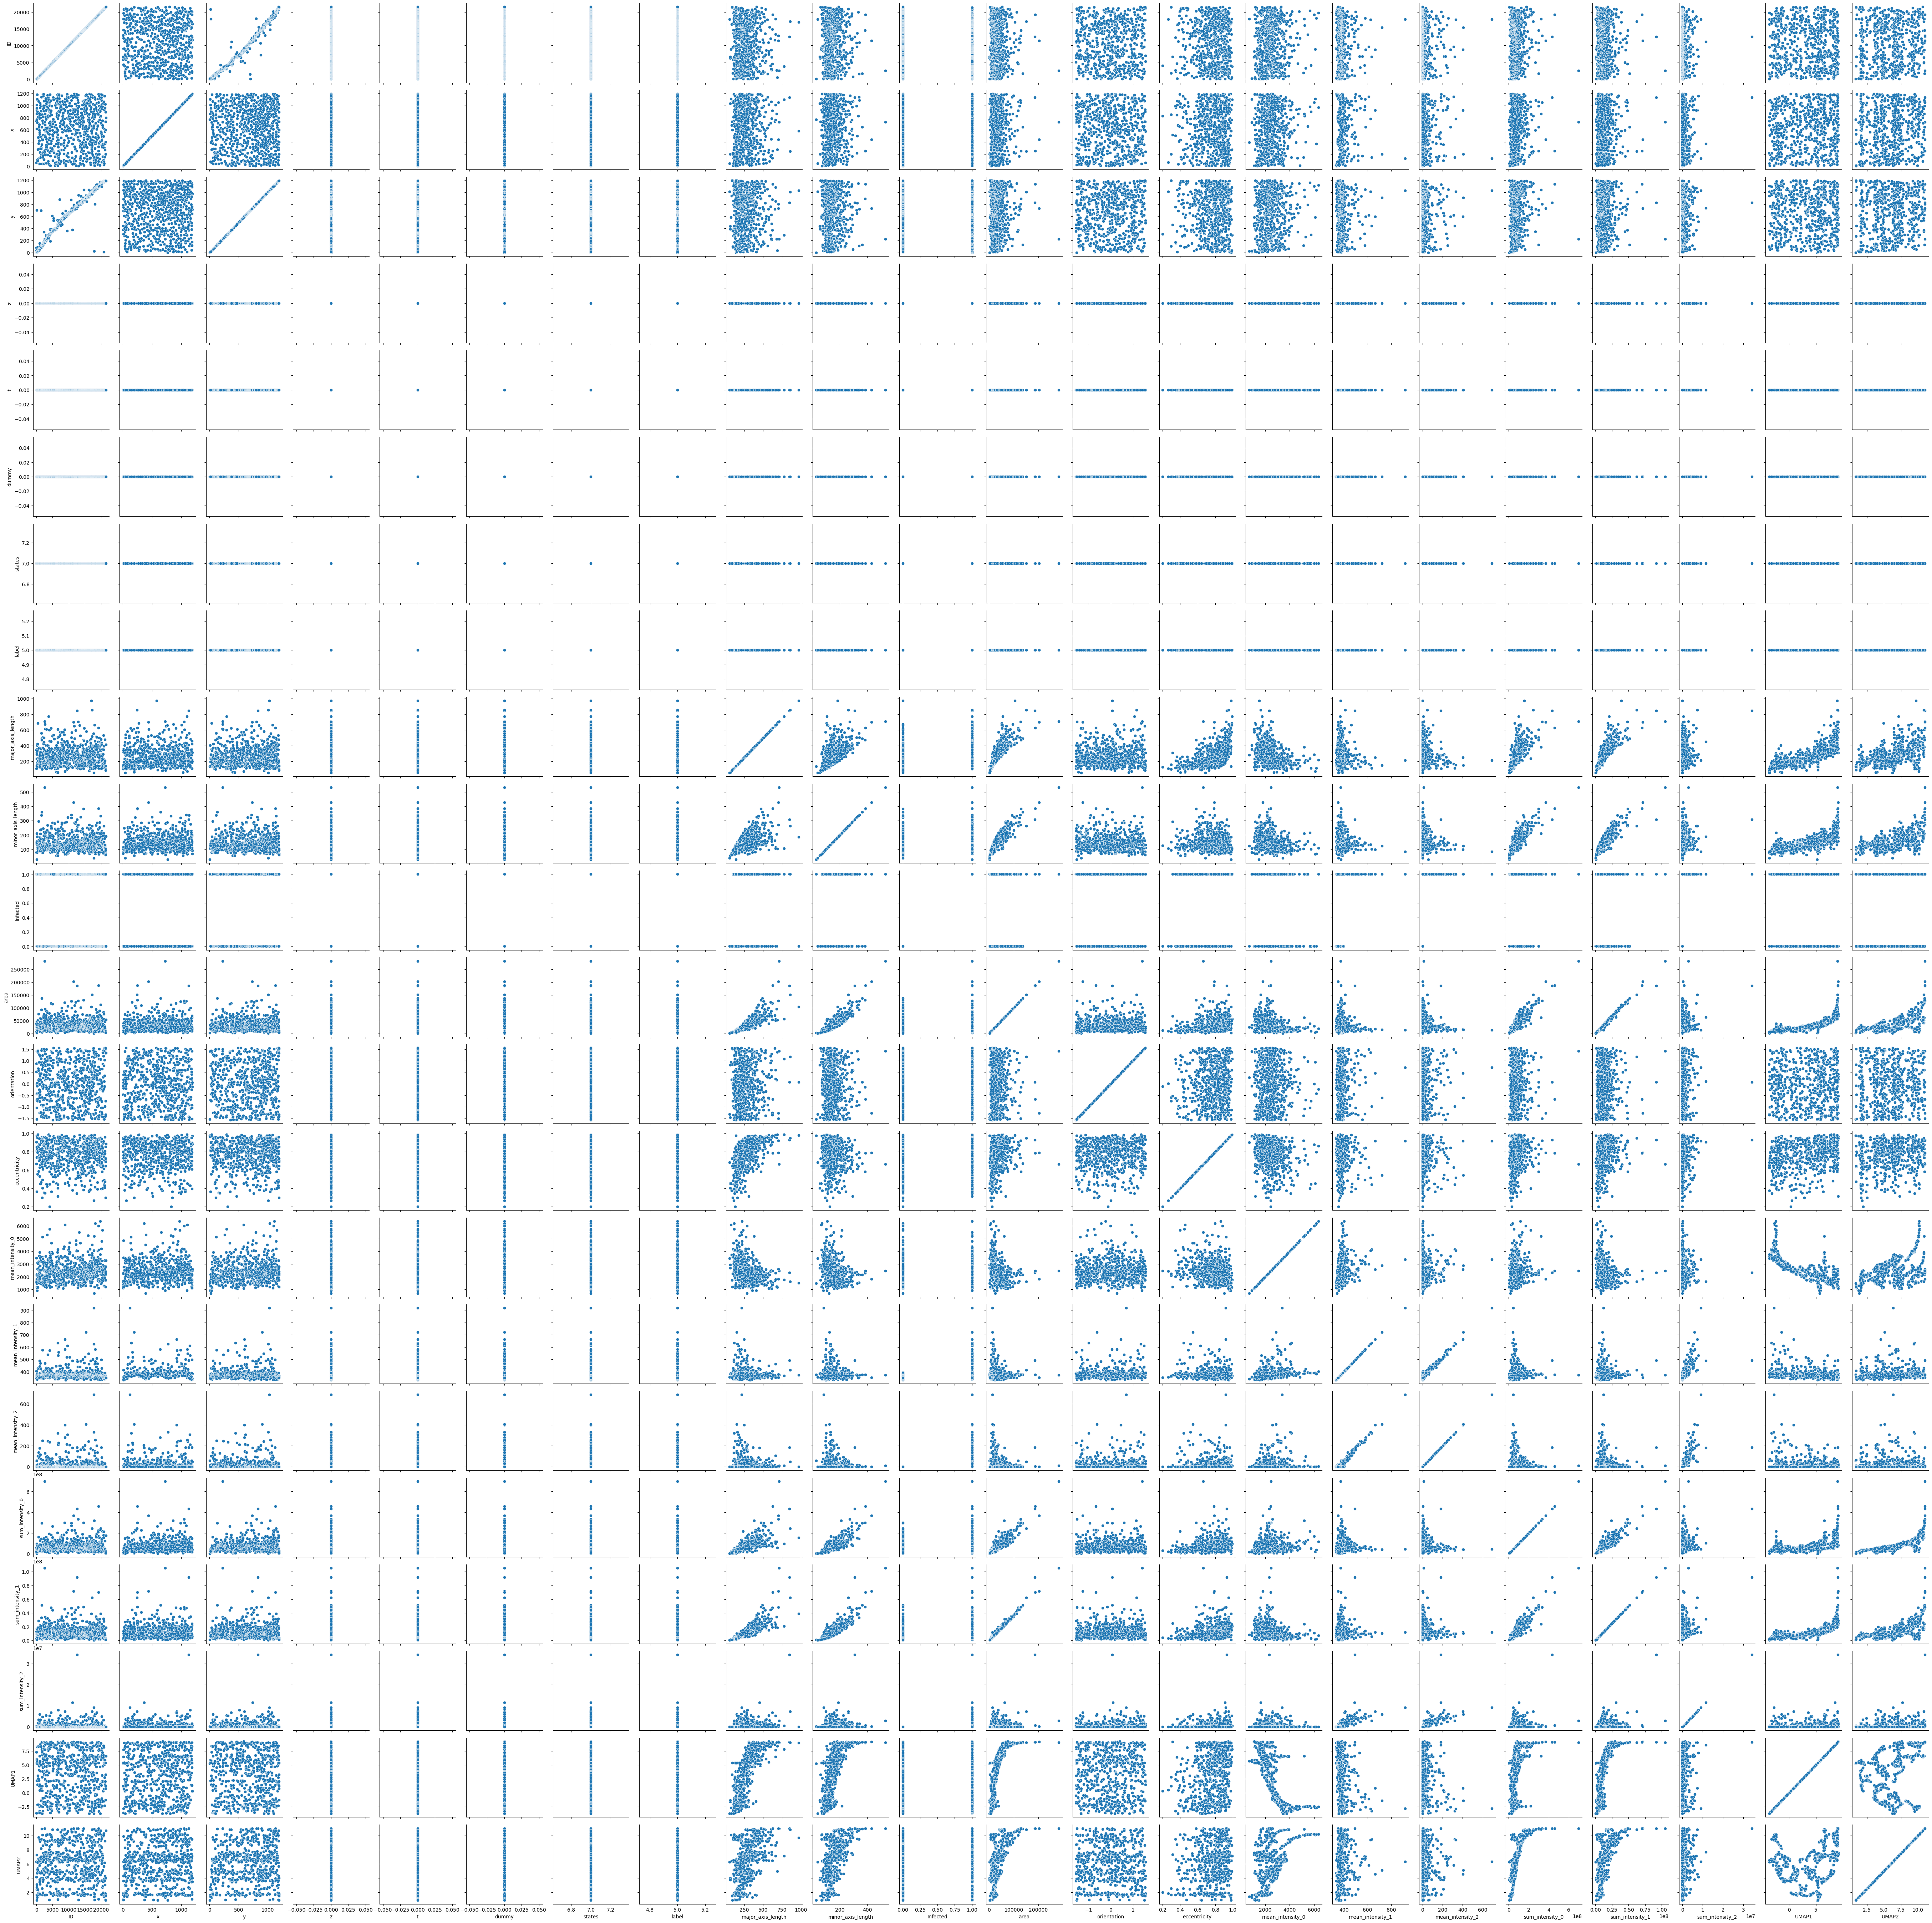

In [89]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

g = seaborn.PairGrid(selected_table)
g.map(seaborn.scatterplot)

## Dimensionality reduction
To demonstrate the UMAP algorithm, we now reduce these three dimensions to two.

In [66]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_statistics)
type(embedding), embedding.shape

(numpy.ndarray, (640, 2))

<AxesSubplot:>

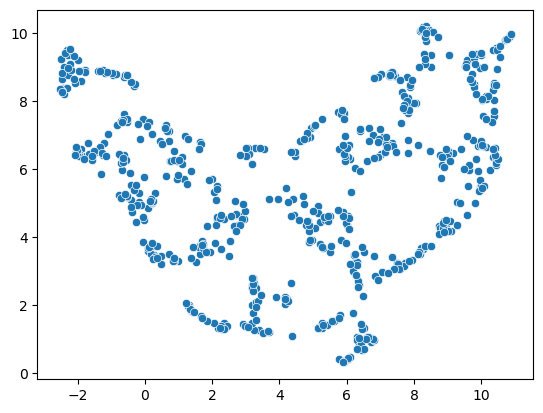

In [90]:
seaborn.scatterplot(x=embedding[:, 0], 
                    y=embedding[:, 1])

## A note on repeatability
The algorithm behind the UMAP is partially a non-deterministic. Thus, if you run the same code twice, the result might look slightly different.

<AxesSubplot:>

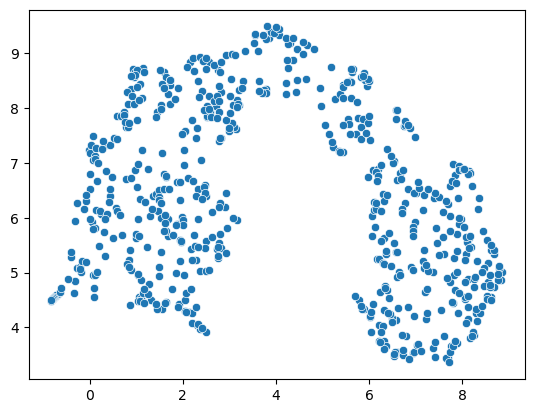

In [91]:
reducer = umap.UMAP()
embedding2 = reducer.fit_transform(scaled_statistics)

seaborn.scatterplot(x=embedding2[:, 0], 
                    y=embedding2[:, 1])

This limitation can be circumvented by providing a non-random seed `random_state`. However, it does not solve the general limitation. If our input data is slightly different, e.g. coming from a different image showing different cells, we may not receive the same UMAP result.

<AxesSubplot:>

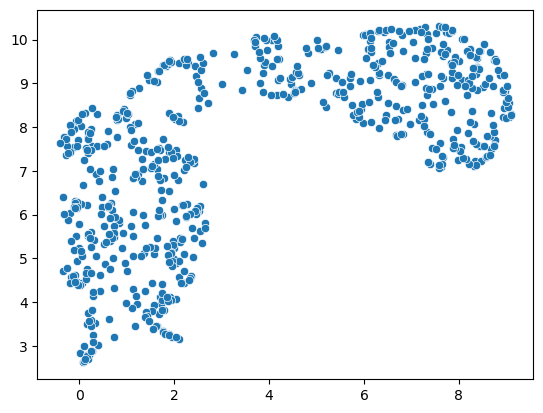

In [92]:
reducer = umap.UMAP(random_state=42)
embedding3 = reducer.fit_transform(scaled_statistics)

seaborn.scatterplot(x=embedding3[:, 0], 
                    y=embedding3[:, 1])

<AxesSubplot:>

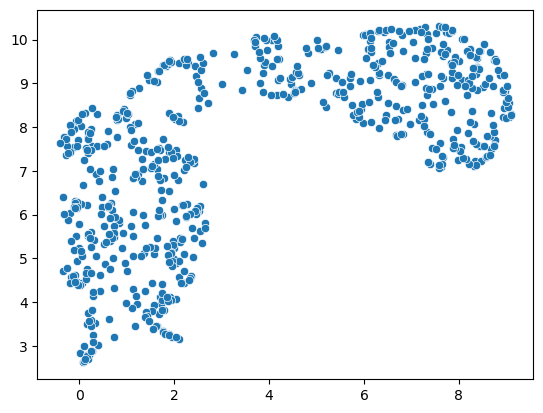

In [93]:
reducer = umap.UMAP(random_state=42)
embedding4 = reducer.fit_transform(scaled_statistics)

seaborn.scatterplot(x=embedding4[:, 0], 
                    y=embedding4[:, 1])

In [94]:
df["UMAP1"] = embedding4[:, 0]
df["UMAP2"] = embedding4[:, 1]

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

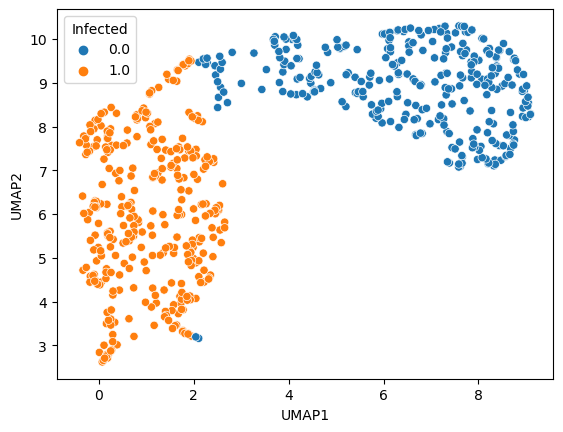

In [95]:
seaborn.scatterplot(
    x=df["UMAP1"],
    y=df["UMAP2"],
    hue=df["Infected"],
)

### Different feature selection

In [97]:
df.keys()

Index(['ID', 'x', 'y', 'z', 't', 'dummy', 'states', 'label',
       'major_axis_length', 'minor_axis_length', 'Infected', 'area',
       'orientation', 'eccentricity', 'mean_intensity_0', 'mean_intensity_1',
       'mean_intensity_2', 'sum_intensity_0', 'sum_intensity_1',
       'sum_intensity_2', 'UMAP1', 'UMAP2'],
      dtype='object')

In [129]:
selected_table = df[
    [
#         "mean_intensity_0",
#         "area",
#         "eccentricity",
        
        "mean_intensity_1",
    ]
]

selected_statistics = selected_table.values

In [130]:
selected_statistics

array([[404.28018],
       [345.92157],
       [379.33984],
       [375.6196 ],
       [359.8808 ],
       [360.89423],
       [361.63452],
       [371.3254 ],
       [352.65692],
       [357.9964 ],
       [337.2962 ],
       [372.39355],
       [384.45032],
       [354.5772 ],
       [363.68665],
       [428.53952],
       [374.90204],
       [363.85217],
       [433.2284 ],
       [372.1818 ],
       [374.86017],
       [348.93903],
       [383.7978 ],
       [353.46216],
       [367.81042],
       [425.73737],
       [372.68564],
       [363.74634],
       [380.7801 ],
       [378.81436],
       [443.92923],
       [370.8946 ],
       [490.00778],
       [380.74545],
       [375.39926],
       [379.86337],
       [390.8583 ],
       [469.3451 ],
       [348.79498],
       [425.53055],
       [385.54422],
       [373.08716],
       [366.09637],
       [382.11502],
       [381.19717],
       [355.72284],
       [376.10568],
       [374.5216 ],
       [384.1775 ],
       [385.3648 ],


In [131]:
scaled_statistics = StandardScaler().fit_transform(selected_statistics)

type(scaled_statistics), scaled_statistics.shape

(numpy.ndarray, (640, 1))

## Plotting
For demonstration purposes, we plot the three selected features against each other. 

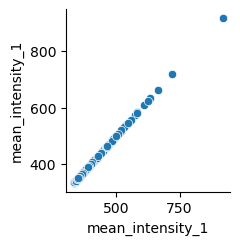

In [132]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

g = seaborn.PairGrid(selected_table)
g.map(seaborn.scatterplot)

## Dimensionality reduction
To demonstrate the UMAP algorithm, we now reduce these three dimensions to two.

In [133]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_statistics)
type(embedding), embedding.shape

(numpy.ndarray, (640, 2))

<AxesSubplot:>

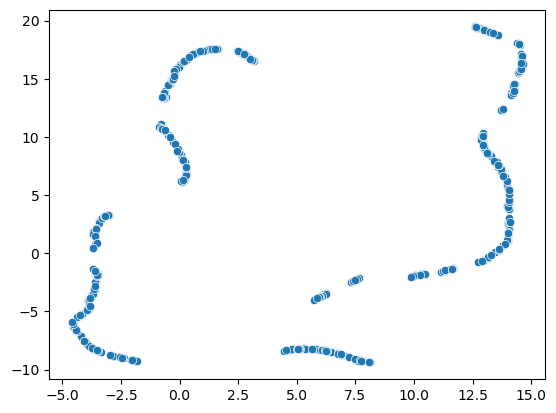

In [134]:
seaborn.scatterplot(x=embedding[:, 0], 
                    y=embedding[:, 1])

In [135]:
df["UMAP1"] = embedding[:, 0]
df["UMAP2"] = embedding[:, 1]

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

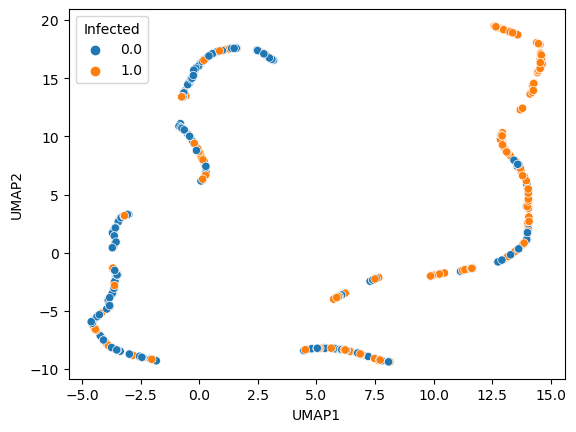

In [136]:
seaborn.scatterplot(
    x=df["UMAP1"],
    y=df["UMAP2"],
    hue=df["Infected"],
)

In [137]:
df.keys()

Index(['ID', 'x', 'y', 'z', 't', 'dummy', 'states', 'label',
       'major_axis_length', 'minor_axis_length', 'Infected', 'area',
       'orientation', 'eccentricity', 'mean_intensity_0', 'mean_intensity_1',
       'mean_intensity_2', 'sum_intensity_0', 'sum_intensity_1',
       'sum_intensity_2', 'UMAP1', 'UMAP2'],
      dtype='object')

### Feature selection

In [113]:
selected_table = df[
    [
        'major_axis_length', 'minor_axis_length', 
#     'Infected', 
        'area',
        'orientation', 'eccentricity', 'mean_intensity_0', 'mean_intensity_1',
        'mean_intensity_2', 'sum_intensity_0', 'sum_intensity_1',
        
        'sum_intensity_2'
    ]
]

selected_statistics = selected_table.values

In [114]:
selected_statistics

array([[1.07259262e+02, 7.98617020e+01, 6.68500000e+03, ...,
        2.32831800e+07, 2.70261300e+06, 3.81711000e+05],
       [3.46958527e+02, 1.44736496e+02, 3.84190000e+04, ...,
        6.09541040e+07, 1.32899610e+07, 1.27550000e+04],
       [3.11702698e+02, 2.10252716e+02, 4.55630000e+04, ...,
        9.56065440e+07, 1.72838620e+07, 0.00000000e+00],
       ...,
       [8.95657654e+01, 6.85957489e+01, 4.48400000e+03, ...,
        5.38107900e+06, 1.60141200e+06, 0.00000000e+00],
       [8.86146164e+01, 6.06968765e+01, 4.12000000e+03, ...,
        7.19567000e+06, 1.45360100e+06, 0.00000000e+00],
       [4.13917084e+02, 1.91538055e+02, 5.34660000e+04, ...,
        1.75494528e+08, 1.87021020e+07, 0.00000000e+00]])

In [115]:
scaled_statistics = StandardScaler().fit_transform(selected_statistics)

type(scaled_statistics), scaled_statistics.shape

(numpy.ndarray, (640, 11))

## Plotting
For demonstration purposes, we plot the three selected features against each other. 

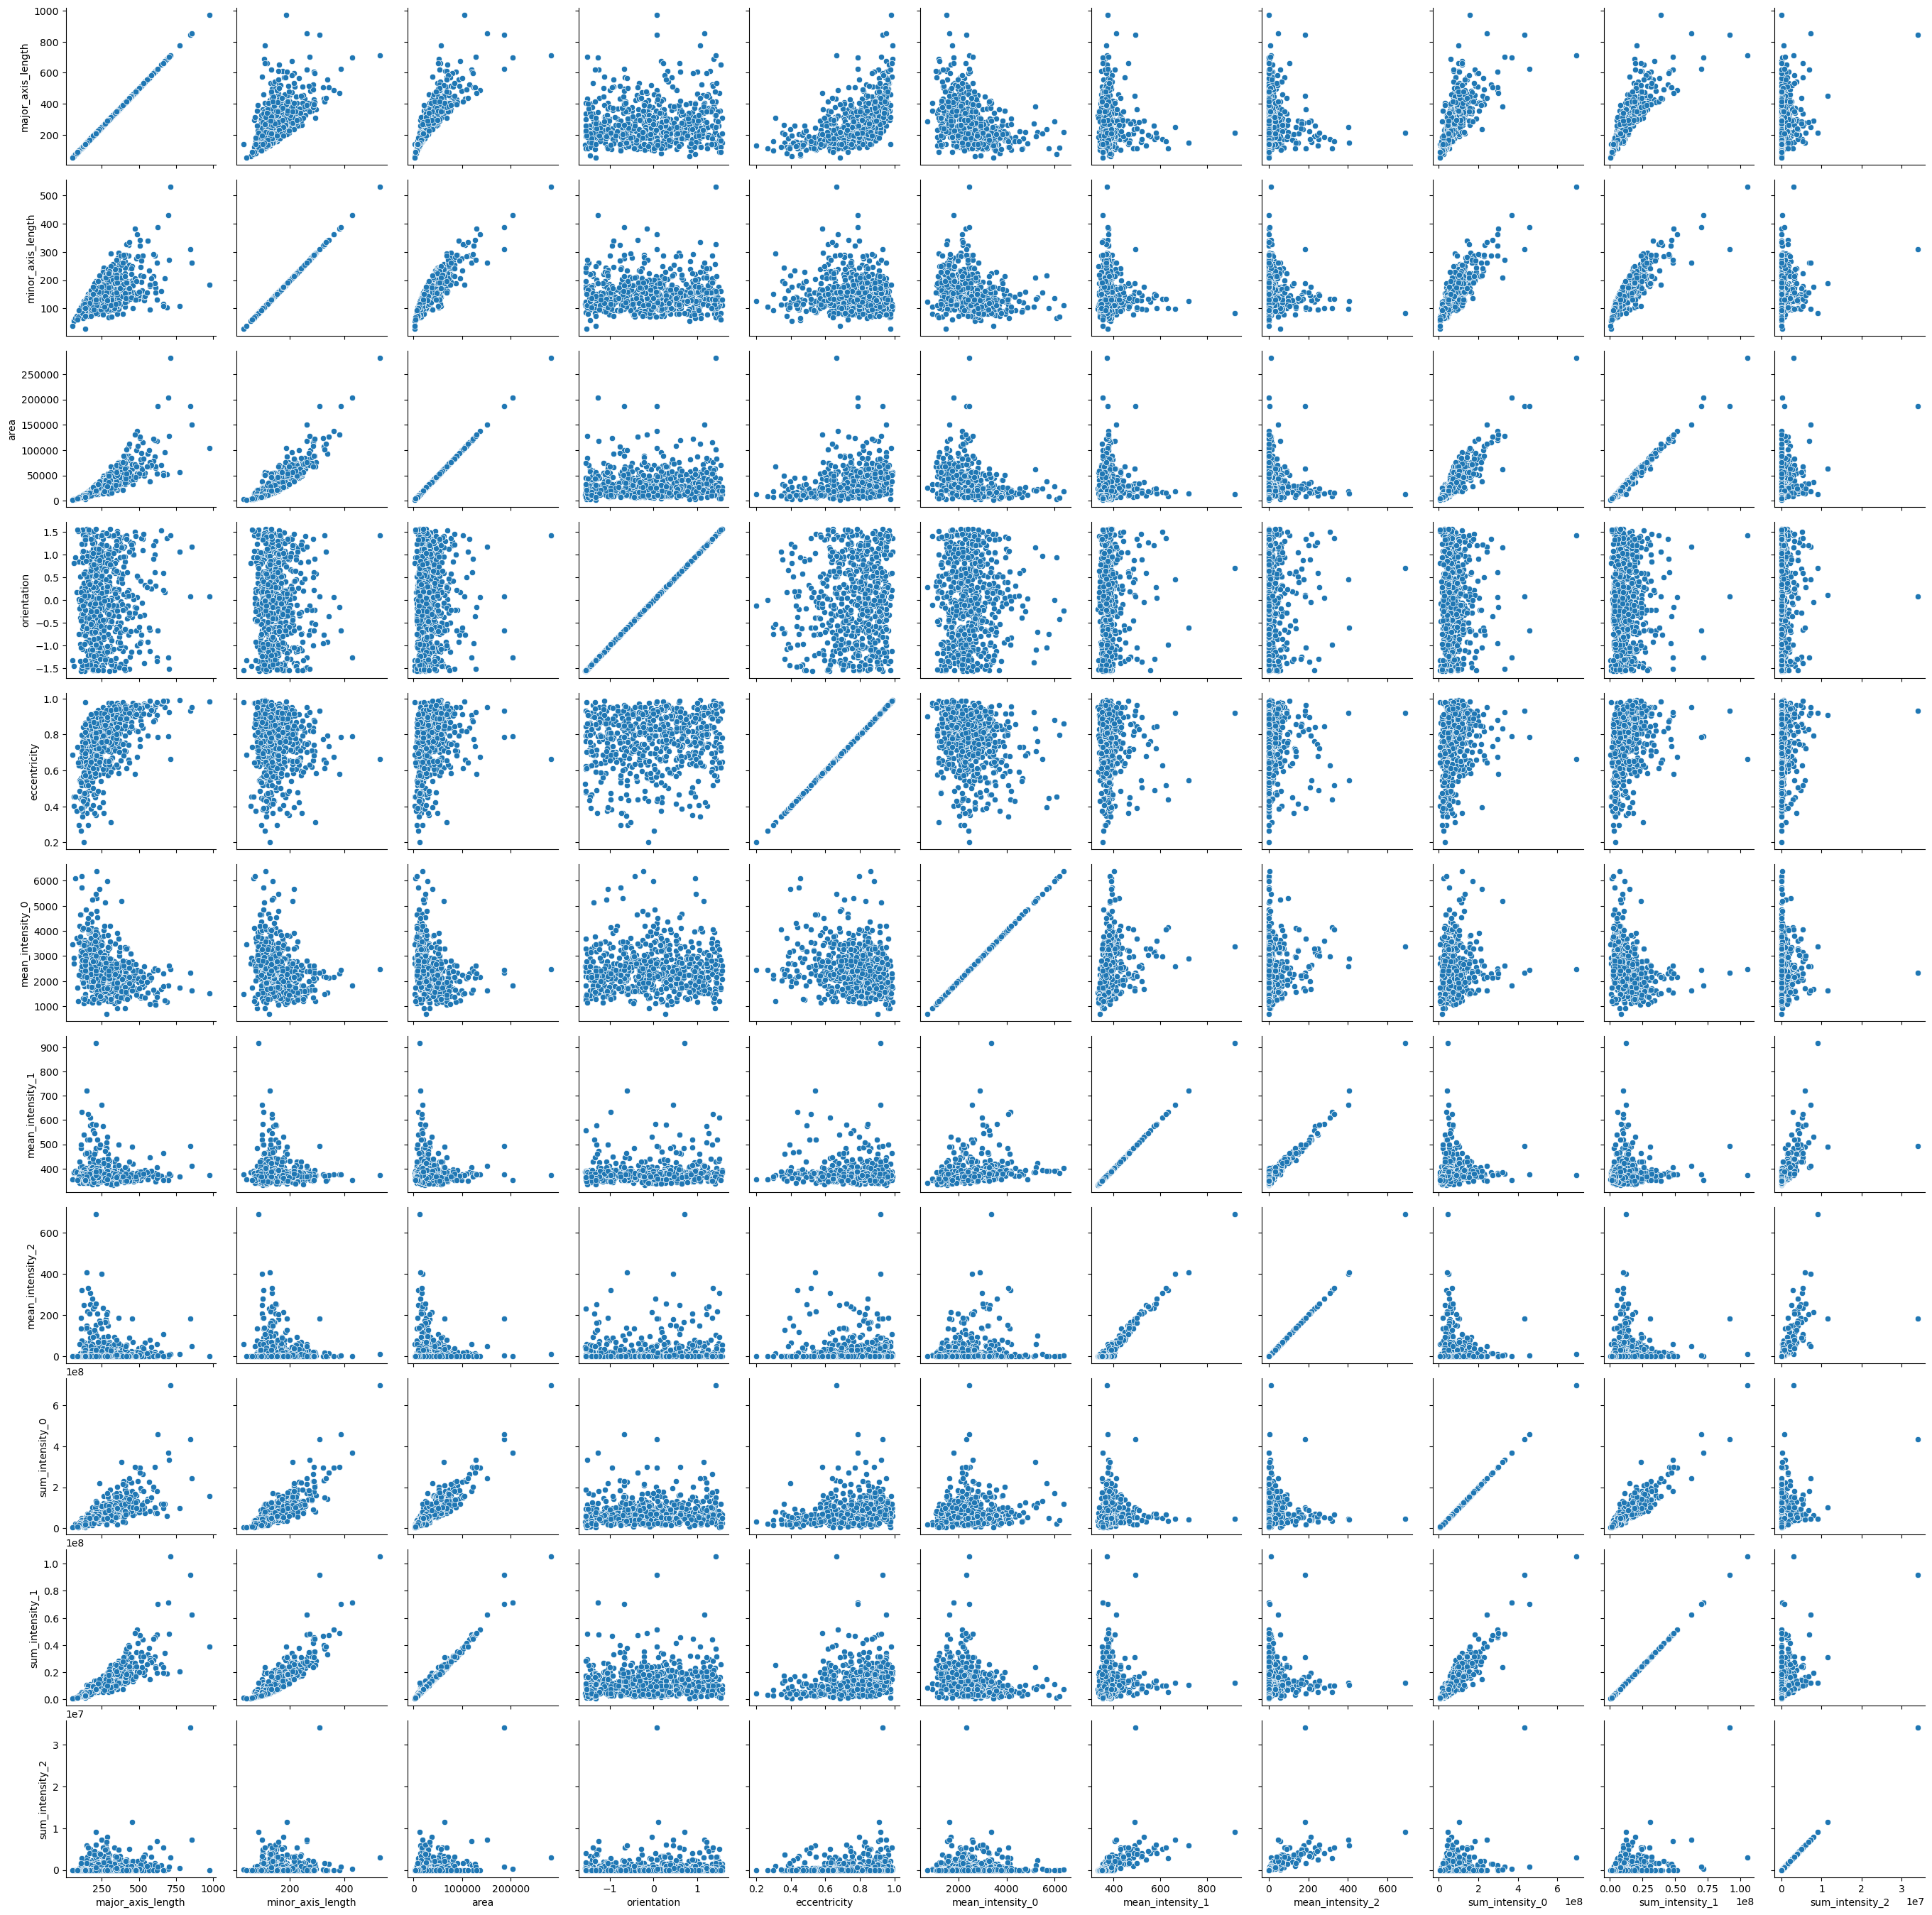

In [116]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

g = seaborn.PairGrid(selected_table)
g.map(seaborn.scatterplot)

## Dimensionality reduction
To demonstrate the UMAP algorithm, we now reduce these three dimensions to two.

In [117]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_statistics)
type(embedding), embedding.shape

(numpy.ndarray, (640, 2))

<AxesSubplot:>

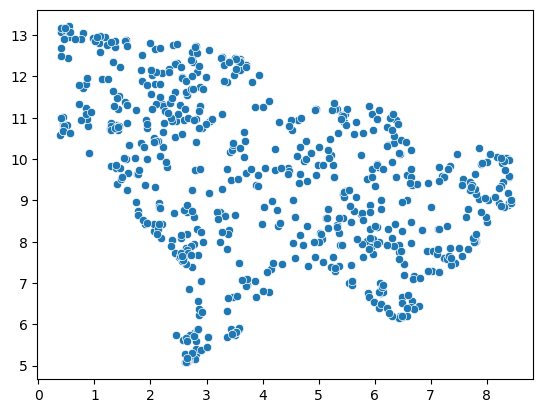

In [118]:
seaborn.scatterplot(x=embedding[:, 0], 
                    y=embedding[:, 1])

In [119]:
df["UMAP1"] = embedding[:, 0]
df["UMAP2"] = embedding[:, 1]

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

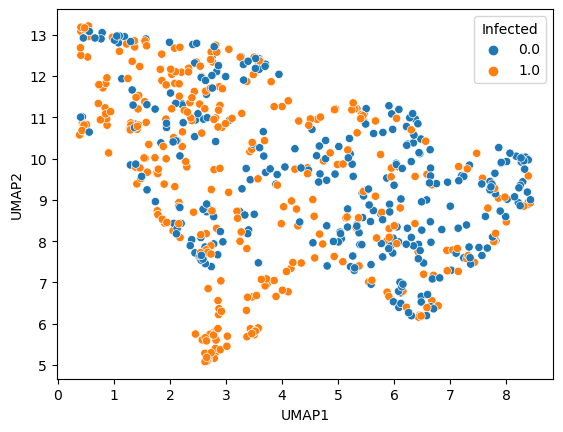

In [120]:
seaborn.scatterplot(
    x=df["UMAP1"],
    y=df["UMAP2"],
    hue=df["Infected"],
)

# Make a corpus of glimpses

Need to couple an object (ie a track at t) to the segmentation... the question is, how to store that glimpse info? If I store a glimpse within an object item then it keeps the other info too...

In [74]:
scale_factor = 5.04

In [75]:
len(objects_t0)

640

In [80]:
thresh_rfp = np.where(rfp>480, rfp, 0)

In [85]:
viewer = napari.Viewer()

viewer.add_image(np.stack([gfp, rfp], axis = 0),  
                 channel_axis=0,
                 name=["macrophage", "mtb"],
                 colormap=["green",  "magenta"],
                 contrast_limits=[[100, 6000], [480, 2000]],
#                  contrast_limits=[[0,450], [0,450]], 
                 visible = False
                 )
viewer.add_image(rfp, contrast_limits=[0,2000])
viewer.add_labels(masks, num_colors=1)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'masks' at 0x7f1b3db7a670>

In [83]:
masks

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [ ]:
viewer.

### Generating an actual corpus

In [76]:
obj = objects_t0[0]

In [154]:
from skimage.measure import regionprops

In [163]:
t = 0
masks = segmentation[t]
gfp = images[t,0,...]#.compute().compute()
# rfp = images[t,1,...]#.compute().compute()
for obj in tqdm(objects_t0):
    coords = int(obj.y*scale_factor), int(obj.x*scale_factor)
    t = obj.t
#     masks = segmentation[t]
#     gfp = images[t,0,...].compute().compute()
#     rfp = images[t,1,...].compute().compute()
    segment_ID = masks[coords]
#     obj.properties['mask'] = masks == [segment_ID]
    segment = masks == [segment_ID]
    # extract bounding box
    bbox = regionprops(segment.astype('u1'))[0].bbox
    x, y, width, height = bbox

    # Slice the image using the bounding box coordinates
    gfp_glimpse = segment[y:y+height, x:x+width] * gfp[y:y+height, x:x+width]
    
    obj.properties['gfp_glimpse'] = gfp_glimpse

  0%|          | 0/640 [00:00<?, ?it/s]

In [164]:
glimpse_stack = np.stack([obj.properties['gfp_glimpse'] for obj in tqdm(objects_t0)])

  0%|          | 0/640 [00:00<?, ?it/s]

ValueError: all input arrays must have the same shape

In [179]:
from skimage.transform import resize

# Find the minimum shape among all arrays
min_shape = np.min([obj.properties['gfp_glimpse'].shape for obj in tqdm(objects_t0)], axis=0)

# Resize all arrays to the minimum shape
resized_stack = np.stack([resize(obj.properties['gfp_glimpse'], min_shape) for obj in tqdm(objects_t0)])


  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

In [174]:
# Find the largest shape among all arrays
max_shape = np.max([obj.properties['gfp_glimpse'].shape for obj in tqdm(objects_t0)], axis=0)

# Create an empty array to store the padded arrays
padded_stack = np.zeros((len(objects_t0), *max_shape), dtype=np.uint16)

# Pad each array to match the largest shape
for i, obj in enumerate(tqdm(objects_t0)):
    array = obj.properties['gfp_glimpse']
    pad_width = [(0, max_shape[dim] - array.shape[dim]) for dim in range(array.ndim)]
    padded_array = np.pad(array, pad_width, mode='constant', constant_values=0)
    padded_stack[i] = padded_array.astype(np.uint16)


  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

In [178]:
[obj.properties['gfp_glimpse'].shape for obj in tqdm(objects_t0)]

  0%|          | 0/640 [00:00<?, ?it/s]

[(2343, 484),
 (413, 304),
 (3098, 2644),
 (2258, 31),
 (1804, 144),
 (1449, 224),
 (1339, 291),
 (1031, 136),
 (712, 121),
 (2444, 341),
 (192, 362),
 (597, 533),
 (1619, 238),
 (515, 513),
 (1691, 284),
 (2098, 215),
 (3051, 314),
 (2459, 275),
 (1942, 373),
 (841, 497),
 (2866, 328),
 (299, 441),
 (1619, 421),
 (2165, 297),
 (1717, 324),
 (3096, 369),
 (2643, 337),
 (2155, 331),
 (2736, 398),
 (836, 358),
 (1896, 419),
 (263, 858),
 (2894, 415),
 (1316, 591),
 (2593, 433),
 (1278, 494),
 (928, 644),
 (1072, 555),
 (2159, 738),
 (798, 490),
 (2495, 607),
 (1726, 2653),
 (1636, 681),
 (1540, 576),
 (1036, 493),
 (545, 832),
 (2998, 912),
 (2056, 600),
 (1014, 630),
 (1126, 547),
 (309, 655),
 (2364, 812),
 (1849, 628),
 (2381, 659),
 (2233, 622),
 (850, 639),
 (1148, 696),
 (165, 692),
 (1146, 670),
 (1457, 799),
 (2630, 745),
 (2573, 873),
 (1006, 812),
 (285, 869),
 (2130, 1010),
 (784, 822),
 (1257, 770),
 (197, 1095),
 (1074, 835),
 (1290, 914),
 (824, 883),
 (400, 1887),
 (761, 1

In [175]:
padded_stack[0].dtype

dtype('uint16')

In [180]:
v = napari.Viewer()
v.add_image(resized_stack)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'resized_stack' at 0x7f94cd060a90>

In [167]:
print()

### Rename properties? Add mask ID as property?

Issue is that once delted from placeholder it is removed from the original objects list

In [18]:
# define features to use for tracking 
features = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "mean_intensity",
  "intensity_image"
    ]
def localise(masks, intensity_image, properties=tuple(features), use_weighted_centroid = False):
    
    # localise objs in images
    objects = btrack.utils.segmentation_to_objects(segmentation=masks,
                                                   intensity_image=intensity_image, 
                                                   properties=properties,
                                                   scale=(scale_factor,scale_factor),
                                                   use_weighted_centroid=use_weighted_centroid, 
                                                   )
                                                   
    return objects


In [33]:
# create pseduo mean intensity with third channel as mask channel
obj1.properties['mean_intensity']

925.25555

In [28]:
obj1.properties

{'minor_axis_length': 81.01919,
 'area': 20624.0,
 'mean_intensity': 925.25555,
 'orientation': -0.10882337,
 'major_axis_length': 334.28482}

In [25]:
obj1.properties['mask_ID'] = obj1.properties['mean_intensity'][-1]
obj1.properties['mean_intensity'] = obj1.properties['mean_intensity'][0:2]

In [26]:
obj1.properties['mean_intensity']

925.25555

# Launch napari image viewer

In [52]:
viewer = napari.Viewer()

viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green",  "magenta"],
#                  contrast_limits=[[100, 6000], [100, 2000]],
                 contrast_limits=[[0,450], [0,450]], 
                 visible = False
                 )
viewer.add_labels(masks, 
#                   num_colors= 1,
                  #scale=(10, 1, 1,), 
                  #color='yellow'
                  name = 'new segmentation'
                 )
# viewer.add_labels(col_segmentation, 
#                   name = 'recolored new segmentation'
#                   #scale=(10, 1, 1,), 
#                   #color='yellow'
#                  )
# viewer.add_tracks(napari_tracks,
# #                     properties=properties, 
# #                     graph=graph, 
#                     name="New model tracks", 
#                     blending="translucent",
#                     visible=True,
#                     scale = (1,5.04,5.04)
#                  )
# viewer.add_tracks(filtered_napari_tracks,
# #                     properties=properties, 
# #                     graph=graph, 
#                     name="New model tracks", 
#                     blending="translucent",
#                     visible=True,
#                     scale = (1,5.04,5.04)
#                  )
# viewer.add_tracks(ds_napari_tracks,
# #                     properties=properties, 
# #                     graph=graph, 
#                     name="downscaled tracks", 
#                     blending="translucent",
#                     visible=True,
# #                     scale = (1,1,1)
#                 )
# viewer.add_labels(ds_segmentation, 
#                  name = 'downscaled segmentation')

# viewer.add_labels(ds_col_segmentation, 
#                   name = 'downscaled coloured segmentation',
#                   scale=(1, 1, 1,), 
# #                   color={1:'yellow'}
#                  )


/home/dayn/analysis/btrack/btrack/dataio.py:3: UserWarning: `btrack.dataio` has been deprecated. Please use `btrack.io` subpackage instead.
  warnings.warn(  # noqa: B028


Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'new segmentation' at 0x7fb326c0a0d0>